We can prove that under assumption $ (H): \rho(|| \Phi ||) < 1, $ the norm kernel matrix satisfies the following equation $$ (C): || \Phi || = I - \Sigma^{1/2} M || c ||^{-1/2} \mbox{ with } M \in O_d (R) \mbox{ and } \int_0^\infty \phi^{ij} \ge 0$$

# Simulation of the Hawkes process with $d$=10

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
import whma.simulation as simu
from mlpp.base.utils import TimeFunction
from whma.metrics import rel_err, rank_corr

In [8]:
# simulation of Hawkes processes
d = 20
mu = 0.5 * np.ones(d)
mus = simu.simulate_mu(d, mu=mu)
blocks = [5,5,10]
L = []
for x in blocks:
    L.append(np.random.rand(x, x))
Alpha_truth = scipy.linalg.block_diag(*L) / 6
# add noise
Alpha_truth += 0.01
Beta = np.random.rand(d**2).reshape((d,d))

In [9]:
#Alpha_truth[2,8] += 0.2

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


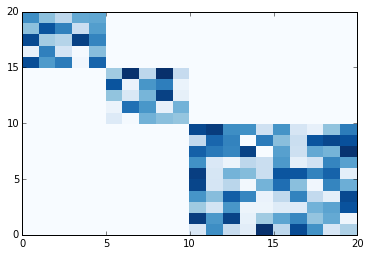

In [10]:
plt.pcolor(Alpha_truth[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [11]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.946283549401


In [12]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
h.simulate(10000)
estim = Estim(h, n_threads=8)

## Correlation matrix

In [13]:
from whma.cumulants import get_C
Corr = get_C(estim)

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


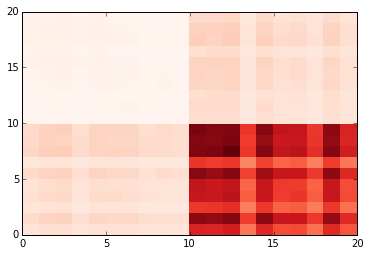

In [14]:
plt.pcolor(Corr[::-1],cmap=plt.cm.Reds)
plt.show()
plt.close()

# Estimation procedure

In [15]:
from whma.solver import admm
import whma.prox as prox
X0 = np.eye(d)
#X0 = np.ones(d**2).reshape(d,d)
rho = 0.001
maxiter = 10000

## objective = squared Frobenius

In [16]:
# main step
X_frob = admm(estim, prox.sq_frob, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)

||X1 - X_2|| =  3.78708844721e-08
||X2 - X_3|| =  1.05318221528e-15
||U1|| =  0.0053695746773
||U2|| =  0.000346408643773
||U3|| =  8.72525784786e-15
||U4|| =  0.00206089994428
||U5|| =  0.000845495712471


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


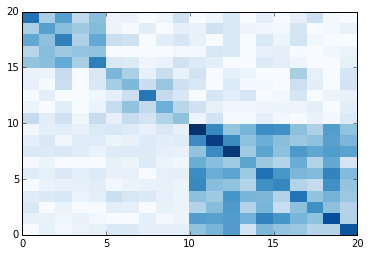

In [17]:
plt.pcolor(X_frob[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [18]:
print("RelErr = ", rel_err(Alpha_truth, X_frob))
print("RankCorr = ", rank_corr(Alpha_truth, X_frob))

RelErr =  0.821870130738
RankCorr =  0.301709329845


## objective = \ell_1 norm

In [19]:
# main step
X_l1 = admm(estim, prox.l1, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)

||X1 - X_2|| =  2.30778061626e-07
||X2 - X_3|| =  2.33657270476e-07
||U1|| =  0.0737698662898
||U2|| =  0.00475423847262
||U3|| =  0.00054060946899
||U4|| =  0.0342616923639
||U5|| =  0.0103253312385


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


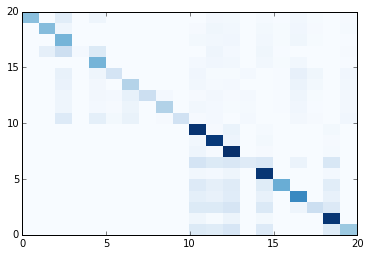

In [20]:
plt.pcolor(X_l1[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [21]:
print("RelErr = ", rel_err(Alpha_truth, X_l1))
print("RankCorr = ", rank_corr(Alpha_truth, X_l1))

RelErr =  1.18928578254
RankCorr =  0.244319393272


## objective = nuclear norm

In [22]:
# main step
X_nuc = admm(estim, prox.nuclear, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)

||X1 - X_2|| =  4.68457831693e-10
||X2 - X_3|| =  1.61288955093e-15
||U1|| =  0.0174969210627
||U2|| =  0.00461494621049
||U3|| =  1.20813819141e-15
||U4|| =  0.00822977108543
||U5|| =  0.00633153629045


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


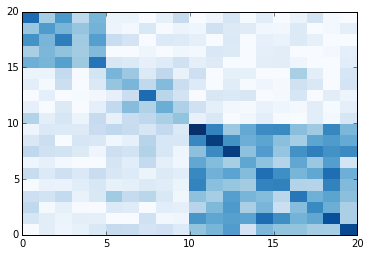

In [23]:
plt.pcolor(X_nuc[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [24]:
print("RelErr = ", rel_err(Alpha_truth, X_nuc))
print("RankCorr = ", rank_corr(Alpha_truth, X_nuc))

RelErr =  0.975854196018
RankCorr =  0.307022514547


## method = matrix Riccati equation

In [25]:
from scipy.linalg import solve_continuous_are
from whma.utils import empirical_sqrt_mean, empirical_sqrt_cross_corr
Lambda = empirical_sqrt_mean(estim.lam)
diagD, O = empirical_sqrt_cross_corr(estim)
A = np.zeros((d, d))
B = np.dot(O,np.dot(np.diag(diagD),O.T))
R = np.eye(d)
Q = np.diag(Lambda)

ImportError: No module named 'whma.utils'

In [ ]:
R_ric = solve_continuous_are(A, B, Q, R)
X_ric = np.eye(d) - R_ric

In [ ]:
plt.pcolor(X_ric[::-1],cmap=plt.cm.Blues)
plt.show()
plt.close()

In [ ]:
print("RelErr = ", rel_err(Alpha_truth, X_ric))
print("RankCorr = ", rank_corr(Alpha_truth, X_ric))